In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.vision.learner import _add_norm

In [2]:
train_df = pd.read_csv('train.csv')
train_df = train_df[~train_df['image_id'].isin(['1562043567.jpg', '3551135685.jpg', '2252529694.jpg'])]

In [3]:
path = Path('')

In [4]:
def get_x(r):
    return path/'train_images'/r['image_id']

def get_y(r):
    return r['label']

In [5]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=get_x,
                 get_y=get_y,
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(train_df, bs=bs)

In [6]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [7]:
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3,
                     init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model  = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [8]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    # adding optimizer in
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [9]:
loss_func = LabelSmoothingCrossEntropy()
#cbs = MixUp

In [10]:
learn = timm_learner(dls, 'efficientnet_b3a', metrics= [accuracy], loss_func=loss_func, opt_func=ranger).to_native_fp16()

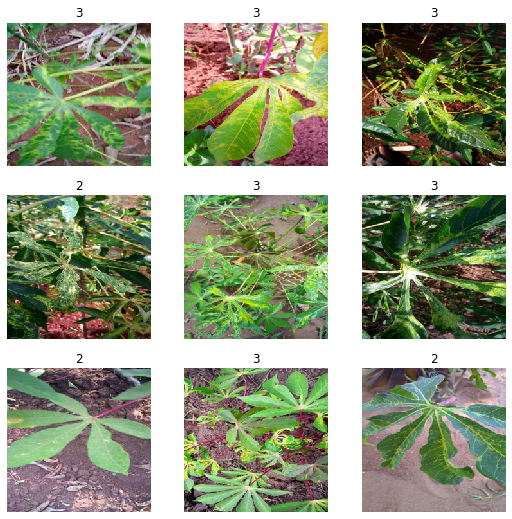

In [11]:
dls.show_batch()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=6.918309736647643e-06)

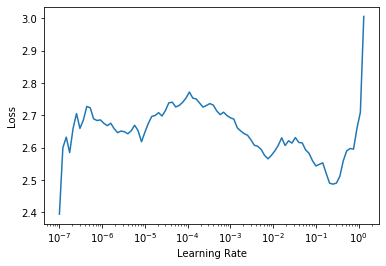

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.087189,0.904951,0.743806,09:33


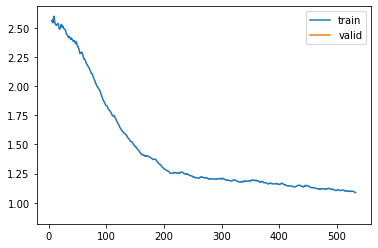

In [13]:
learn.fit_flat_cos(1,1e-2, cbs=[GradientAccumulation(), MixUp(), ReduceLROnPlateau()])
learn.recorder.plot_loss()

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=8.31763736641733e-06)

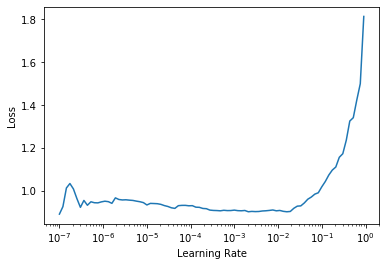

In [14]:
learn.unfreeze()
learn.lr_find()

In [15]:
learn.fit_flat_cos(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.756723,0.721333,0.838476,12:32
1,0.720473,nan,0.848060,12:34
2,0.697506,0.700114,0.854605,12:34
3,0.672340,0.697661,0.852501,12:33
4,0.600337,0.716171,0.853904,12:34
5,0.590896,0.707156,0.852034,12:34
6,0.564134,0.727792,0.852267,12:34
7,0.550022,0.733136,0.847359,12:34
8,0.465652,0.726247,0.855306,12:34
9,0.439223,0.727945,0.858579,12:34


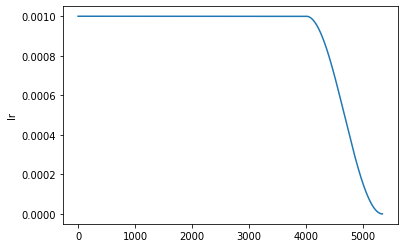

In [17]:
learn.recorder.plot_sched()

In [19]:
# import timm
# #timm.list_models()[:10]
# timm.list_models('*efficientnet*')[:10]

In [18]:
#learn.save('b3')

In [20]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=384, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=get_x,
                 get_y=get_y,
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(train_df, bs=bs)

In [22]:
learn.dls = dls

In [27]:
learn.load('b3')

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10,1e-5, cbs=[GradientAccumulation(), MixUp(), ReduceLROnPlateau(), SaveModelCallback(every_epoch=True), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))])

In [ ]:
learn.save('b3_384')